## Imports

In [1]:
import random
%matplotlib inline
import cv2
import torch
import numpy as np
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
from torch.optim import RMSprop
from skimage import data, io, filters
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt

## Part A

### Converting the image to binary

Dimensions of the image are: (512, 512)


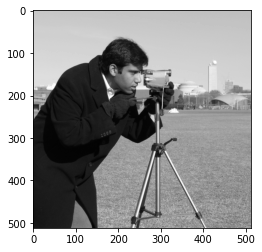

In [2]:
# Standard text image used for denoiseing
cameraman = data.camera()
print("Dimensions of the image are:", cameraman.shape)
plt.imshow(cameraman, cmap='gray')

In [3]:
gt = cameraman
cameraman = cameraman/255

In [4]:
# create gaussian noise
x, y = cameraman.shape
print("Nd array of image cameraman : \n",cameraman)
mean = 0
var = 0.01
sigma = np.sqrt(var)
Gaussian_noise = np.random.normal(loc=mean, scale=sigma, size=(x,y))
print("Gaussian Noise Nd - array : \n", Gaussian_noise)

Nd array of image cameraman : 
 [[0.78431373 0.78431373 0.78431373 ... 0.74117647 0.74509804 0.74509804]
 [0.78431373 0.78039216 0.78039216 ... 0.74509804 0.74509804 0.74509804]
 [0.78039216 0.78039216 0.78039216 ... 0.74509804 0.74509804 0.74509804]
 ...
 [0.09803922 0.09803922 0.10588235 ... 0.54509804 0.47843137 0.57647059]
 [0.09803922 0.09803922 0.10196078 ... 0.61960784 0.55294118 0.65882353]
 [0.09803922 0.09803922 0.10588235 ... 0.59215686 0.59607843 0.58431373]]
Gaussian Noise Nd - array : 
 [[-0.04116814 -0.07713213  0.05116778 ...  0.05567979  0.0085056
   0.03344691]
 [ 0.0108008   0.11369657 -0.14628409 ... -0.14104966 -0.23738286
  -0.03652467]
 [ 0.08037775 -0.00197434  0.03568814 ...  0.18364631  0.07978468
  -0.04900166]
 ...
 [-0.19687367  0.17758956 -0.16143049 ...  0.13415258 -0.03373959
   0.04799209]
 [ 0.00311712  0.09011398  0.03470177 ... -0.00850811  0.14065929
  -0.06025048]
 [ 0.10363599 -0.0043045   0.06196087 ...  0.00716953  0.01622037
   0.12950085]]


# Adding Gaussian Noise


Noisy gaussian Nd - array : 

[[ 0.74314559  0.70718159  0.83548151 ...  0.79685626  0.75360364
   0.77854495]
 [ 0.79511453  0.89408873  0.63410807 ...  0.60404838  0.50771518
   0.70857337]
 [ 0.86076991  0.77841782  0.8160803  ...  0.92874435  0.82488272
   0.69609638]
 ...
 [-0.09883446  0.27562877 -0.05554814 ...  0.67925062  0.44469178
   0.62446268]
 [ 0.10115634  0.1881532   0.13666255 ...  0.61109973  0.69360047
   0.59857305]
 [ 0.2016752   0.09373471  0.16784323 ...  0.59932639  0.61229881
   0.71381457]]


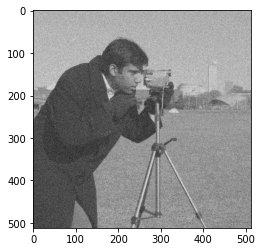

In [5]:
g = cameraman + Gaussian_noise
noisy = g
print("Noisy gaussian Nd - array : \n")
print(noisy)
g = g*255
plt.imshow(g, cmap='gray')

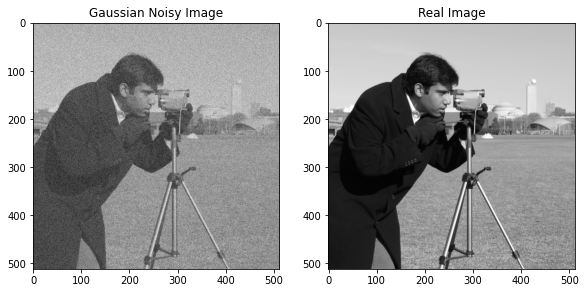

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Gaussian Noisy Image')
plt.imshow(g, cmap='gray')
plt.subplot(132)
plt.title('Real Image')
plt.imshow(gt, cmap='gray')
plt.show()

In [7]:
def binarize_img(im):
    bin_im = im / 255.
    bin_im.flags.writeable = True
    bin_im[bin_im < 0.5] = 0
    bin_im[bin_im >= 0.5] = 1
    return bin_im

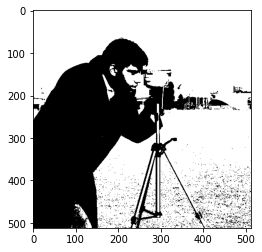

In [8]:
bin_cameraman = binarize_img(gt)
plt.imshow(bin_cameraman, cmap='gray')

### Adding Noise

In [9]:
def add_noise(orig_img, thresh):

    N, M = orig_img.shape
    noisy_img = orig_img.copy()
    Gaussian_noise = np.random.rand(N, M)
    Gaussian_noise[Gaussian_noise < 1-thresh] = 0
    Gaussian_noise[Gaussian_noise >= 1-thresh] = 1

    noisy_img = (noisy_img + Gaussian_noise) % 2
    
    return noisy_img

# We try to introduce Some sample of noisy Image's in which we introduce Some percentage of noise on the basis of 0.05 threshold value.

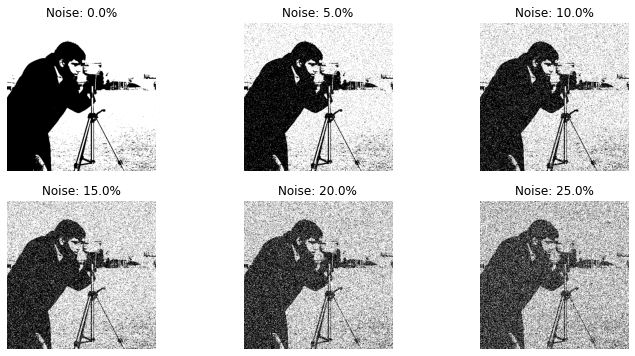

In [10]:
fig = plt.figure(figsize=(12, 6))

for i in range(0, 5 + 1):
    thresh = i/20
    noisy_img = add_noise(bin_cameraman, thresh)
    plt.subplot(2, 3, i+1)
    plt.title(f'Noise: {thresh*100}%')
    plt.axis('off')
    plt.imshow(noisy_img, cmap='gray')
plt.show()

# Denoising the image using the probability distrubution of neighbour of random variable i given j set of random variable of Neighbour node's

In [ ]:
def get_neighbours(i, j, M, N):
    neighbours = []
    if i > 0:
        neighbours.append([i-1, j])
    if i < M-1:
        neighbours.append([i+1, j])
    if j > 0:
        neighbours.append([i, j-1])
    if j < N-1:
        neighbours.append([i, j+1])

    return neighbours

In [ ]:
def enrg(new, old, y, neighbours):
    lmda = -100
    return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)

In [ ]:
def diff(y, y_old):
    diff = abs(y - y_old) / 2
    return (100.0 * np.sum(diff)) / np.size(y)

In [ ]:
def denoise(noisy_img):
    M, N = noisy_img.shape
    y = noisy_img.copy()
    maxiter = 5*M*N

    for iter in range(maxiter):
        i = np.random.randint(M)
        j = np.random.randint(N)
        neighbours = get_neighbours(i, j, M, N)

        enrg_1 = enrg(1, y[i, j], y, neighbours)
        enrg_0 = enrg(0, y[i, j], y, neighbours)

        if enrg_1 > enrg_0:
            y[i, j] = 1
        else:
            y[i, j] = 0
        
        if iter % 100000 == 0:
            print (f'Completed {iter} iterations out of {maxiter}. Denoized pixels are: {diff(y, noisy_img)}%')

    return y

## Testing

Denoising for noise level: 5.0
Completed 0 iterations out of 1310720. Denoized pixels are: 0.0%


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10640\2671395374.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)


Completed 100000 iterations out of 1310720. Denoized pixels are: 1.3982772827148438%
Completed 200000 iterations out of 1310720. Denoized pixels are: 2.2411346435546875%
Completed 300000 iterations out of 1310720. Denoized pixels are: 2.7484893798828125%
Completed 400000 iterations out of 1310720. Denoized pixels are: 3.0897140502929688%
Completed 500000 iterations out of 1310720. Denoized pixels are: 3.3250808715820312%
Completed 600000 iterations out of 1310720. Denoized pixels are: 3.4608840942382812%
Completed 700000 iterations out of 1310720. Denoized pixels are: 3.5869598388671875%
Completed 800000 iterations out of 1310720. Denoized pixels are: 3.673553466796875%
Completed 900000 iterations out of 1310720. Denoized pixels are: 3.739166259765625%
Completed 1000000 iterations out of 1310720. Denoized pixels are: 3.7969589233398438%
Completed 1100000 iterations out of 1310720. Denoized pixels are: 3.8301467895507812%
Completed 1200000 iterations out of 1310720. Denoized pixels are:

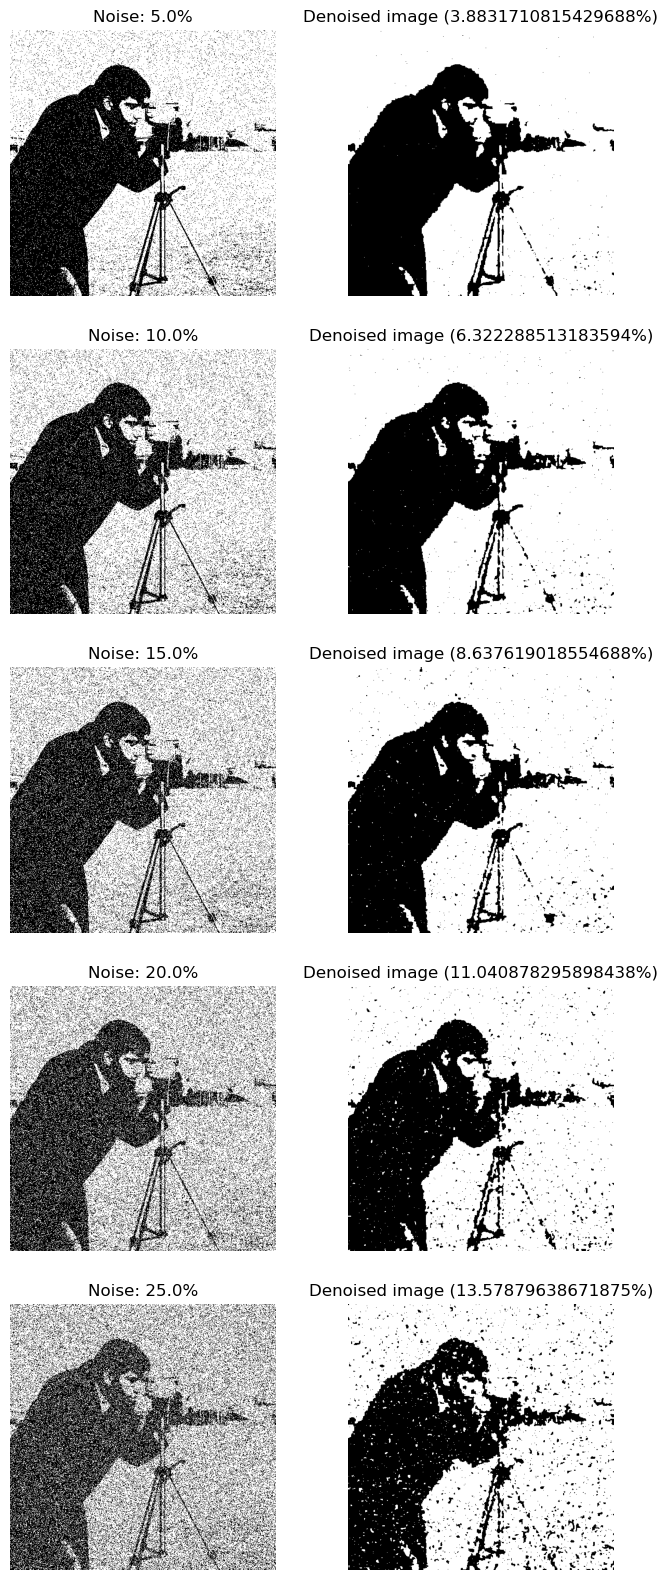

In [ ]:
fig = plt.figure(figsize=(8, 20))

for i in range(1, 5 + 1):
    thresh = i/20
    print(f"Denoising for noise level: {thresh*100}")

    noisy_img = add_noise(bin_cameraman, thresh)
    denoised_img = denoise(noisy_img)

    plt.subplot(5, 2, 2*i-1)
    plt.title(f'Noise: {thresh*100}%')
    plt.axis('off')
    plt.imshow(noisy_img, cmap='gray')

    plt.subplot(5, 2, 2*i)
    plt.title(f'Denoised image ({diff(noisy_img, denoised_img)}%)')
    plt.axis('off')
    plt.imshow(denoised_img, cmap='gray')

    print()
plt.show()

# ============================================================
# Relative Root Mean Squared Error Analysis  

In [ ]:
def mrf_prior(x):
    return x**2

def mrf_potential(X, noisy, a):
    # energy_1 is reconstruction loss
    energy_1 = ((noisy - X)**2).sum()
    # energy_2 defines neighbourhood potentials
    energy_2 = 0
    energy_2 += mrf_prior(X[:, 1: ] - X[:, :-1]).sum()
    energy_2 += mrf_prior(X[:-1, :] - X[ 1:, :]).sum()
    energy_2 += mrf_prior(X[:-1,:-1] - X[1:, 1:]).sum()
    energy_2 += mrf_prior(X[1:, :-1] - X[ :-1, 1:]).sum()
    return energy_1 + a*energy_2*2

In [ ]:
to_tensor = ToTensor()
noisy = to_tensor(noisy)[0]
gt    = to_tensor(gt)[0]

In [ ]:
to_tensor = ToTensor()
RRMSE = lambda x: (((gt - x)**2).sum() / (gt**2).sum())**0.5
X = torch.zeros_like(noisy)
X.requires_grad = True
errors = []
losses = []
images = []
alpha  = 0.15
optimizer = RMSprop([X])
n_it   = 100

In [ ]:
for it in range(n_it):
    optimizer.zero_grad()
    loss = mrf_potential(X, noisy, alpha)
    loss.backward()
    optimizer.step()
    errors.append(RRMSE(X).cpu().detach())
    losses.append(loss.item())
    images.append(np.array(X.cpu().detach()).astype(np.uint8))

RRMSE Initial: 0.17178742420692128
RRMSE Final  : 0.08032410988951892


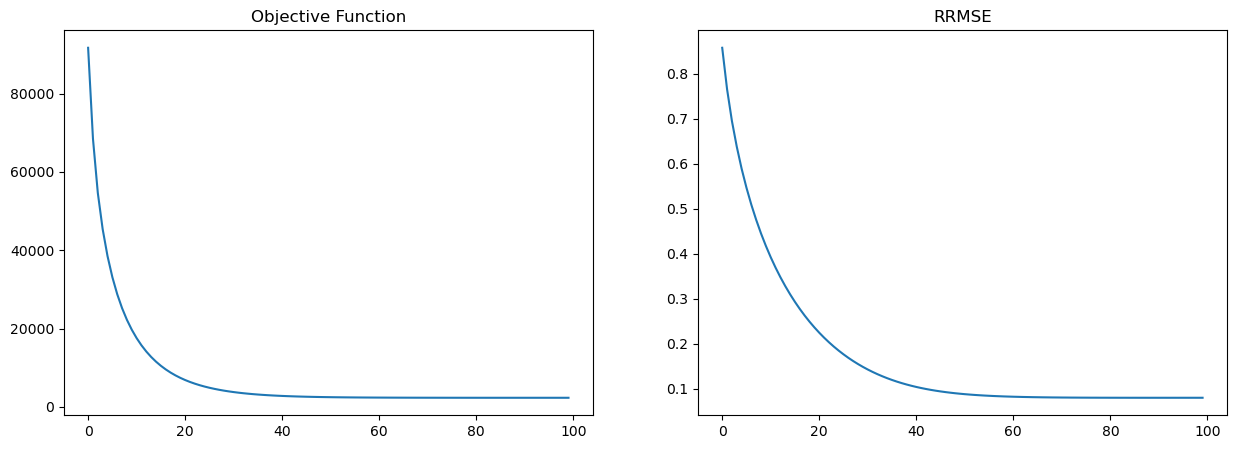

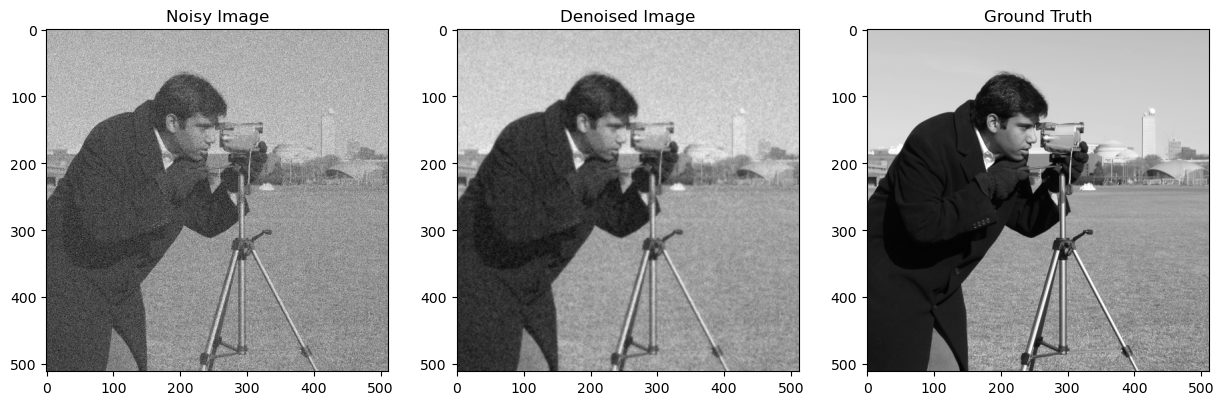

In [ ]:
print("RRMSE Initial: {}".format(RRMSE(noisy)))
print("RRMSE Final  : {}".format(errors[-1]))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Objective Function')
plt.plot(losses)
plt.subplot(122)
plt.title('RRMSE')
plt.plot(errors)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(noisy.cpu(), cmap='gray')
plt.subplot(132)
plt.title('Denoised Image')
plt.imshow(X.detach().cpu(), cmap='gray')
plt.subplot(133)
plt.title('Ground Truth')
plt.imshow(gt.cpu(), cmap='gray')
plt.show()

# ---------------------------------------------------------------------------------------------------------------

# Conclusion
 ### - Initially when we denoised our noisy image we will train our epoches and for every epoches we getting some objective function loss at every epoche's.
 ### - Parallaley we getting relative root mean squared error curve for every epoche's.
 ### - we will be getting denoised image after energy minimization. and try to compare with ground truth which is our real image we can clearly seen some of the noise will removed by minimzation of energy with conditional probability of neighbour node through normalization of product of minimal click's which is our subset of random variable taken from X.
 ### - we successfully do our task of image denoiseing